<a href="https://colab.research.google.com/github/tamaricki/Projects/blob/main/brainScans_classification_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Scan Images classification with help of transfer learning

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

os.chdir('/content/drive/MyDrive')

In [3]:
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import glob

In [4]:

train_list = glob.glob('./Training/*/*.jpg')
path = './Training'

test_list = glob.glob('./Testing/*/*.jpg')


In [20]:
print(train_list[-3:])
print(test_list[-3:])

['./Training/pituitary_tumor/p (687).jpg', './Training/pituitary_tumor/p (745).jpg', './Training/pituitary_tumor/p (563).jpg']
['./Testing/pituitary_tumor/image(3).jpg', './Testing/pituitary_tumor/image(19).jpg', './Testing/pituitary_tumor/image(67).jpg']


In [36]:
print('Train folder contains {} images , and test {} images.'.format(len(train_list), len(test_list)))

Train folder contains 2870 images , and test 394 images.


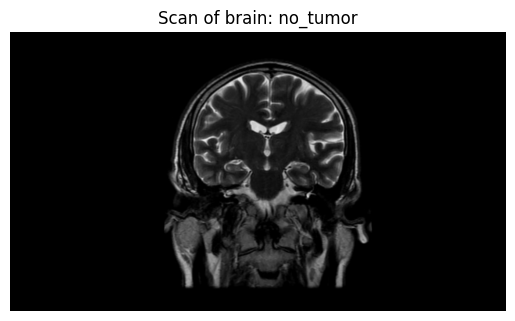

In [41]:
plt.imshow(plt.imread(train_list[2001]))
plt.title('Scan of brain: '+ train_list[2001].split('/')[2])
plt.axis('off')
plt.show()

In [ ]:
image = np.array(plt.imread(train_list[1022]))
image.shape

(500, 455, 3)

- Images are saved in 4 folders each one for each class of brain scan
- As next step, images will be transformed in tensor, size will change, pixels will be normalized .
- Order of Steps for image transformation is important


In [6]:

train_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

dataset_train_resnet = ImageFolder(path, transform=train_transforms)

In [7]:
test_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
dataset_test_resnet = ImageFolder('./Testing', transform=test_transforms)

In [8]:
print(dataset_train_resnet.class_to_idx)
print(dataset_test_resnet.class_to_idx)

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


In [9]:
dataset_train_resnet[9][0].shape # check the image shape

torch.Size([3, 224, 224])

In [9]:
dataloader_train_resnet= DataLoader(dataset_train_resnet, batch_size=4, shuffle=True)
dataloader_test_resnet =DataLoader(dataset_test_resnet, batch_size=4, shuffle=True)

train_size = len(dataset_train_resnet)
train_size1 = len(dataloader_train_resnet.dataset)
test_size =len(dataset_test_resnet)
test_size1 = len(dataloader_test_resnet.dataset)

#sizes of dataset and dataloader
print('Train: ', train_size, train_size1, len(dataloader_train_resnet) )
print('test: ', test_size, test_size1, len(dataloader_test_resnet))

Train:  2870 2870 718
test:  394 394 99


In [10]:
class_names = dataset_train_resnet.classes
class_names

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])


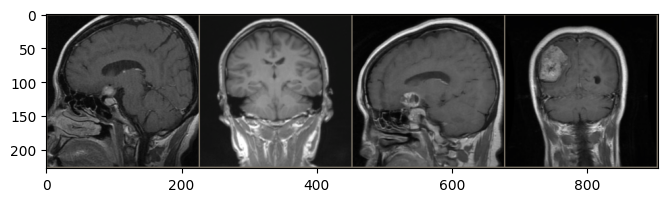

In [11]:
#visualizing images

example, label = next(iter(dataloader_train_resnet))
print(example.size())
print(example.size()[1:])

def show_grid(p):
  mean = [0.485, 0.456, 0.406]
  std = [0.229, 0.224, 0.225]
  new1 = p.numpy().transpose((1,2,0))
  new = new1*std + mean

  new[new>1] = 1
  new[new <0] = 0
  plt.figure(figsize=(20,2))
  plt.imshow(new)


n_img = 6

out_images = torchvision.utils.make_grid(example[:n_img])
show_grid(out_images)



### Training and Validation functions

Let's create training and testing functions.

In [12]:
print(torch.__version__)
use_gpu = torch.cuda.is_available()
print(use_gpu)


2.1.0+cu118
True


In [24]:

def model_validate(model, loader, optimizer):
  model.eval()
  run_loss = 0.0
  run_acc = 0.0
  with torch.no_grad():
    batch_count = 0
    for data in loader:
      img, label = data
      img, label = img.to(device), label.to(device)
      output = model(img)

      loss = criterion(output, label)
      _, preds = torch.max(output.data, 1)

      run_loss +=loss.item()
      run_acc += torch.sum(preds==label).item()

    #avg_loss = run_loss/batch_count
    e_loss = run_loss/len(loader.dataset)
    e_acc = run_acc/len(loader.dataset)
    print('Validation loss:, {} | Validation accuracy: {}'.format(e_loss, e_acc))





def model_train_validate(model, train_loader, val_loader, optimizer, epochs):

  model.train()
  for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch+1, epochs))
    run_loss = 0.0
    run_acc = 0.0
    for data in train_loader:
      optimizer.zero_grad()
      feature, label = data
      feature, label = feature.to(device), label.to(device)
      outputs = model(feature)

      loss = criterion(outputs, label)
      _, preds = torch.max(outputs, 1)
      run_loss += loss.item()
      run_acc += torch.sum(preds==label)

      loss.backward()
      optimizer.step()

    e_loss = run_loss / len(train_loader.dataset)
    e_acc = run_acc / len(train_loader.dataset)
    print('Training Loss : {} | Training Accuracy:{} '.format(e_loss, e_acc))

    model_validate(model, val_loader, optimizer)




In [25]:
resnet = models.resnet18(weights='IMAGENET1K_V1')
#print(resnet)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

This takes too long to perform on colab, therefore, we should use transfer learning for this task. We will try with Resnet18. But for that we need to change the classifier part of the model and during training we might need to change the input (features) shape - make it one dimensional

In [26]:
for w in resnet.parameters(): # freezing parameters so they don't change during training
    w.requires_grad=False

resnet.fc = nn.Linear(in_features=512, out_features = 4) # changing the classifier part of model, by providing number of classes

resnet_opt = torch.optim.SGD(resnet.parameters(), lr=0.001)

resnet.to(device)
criterion = nn.CrossEntropyLoss()

In [27]:
model_train_validate(resnet, dataloader_train_resnet, dataloader_test_resnet, resnet_opt, 35)



Epoch 1/35
Training Loss : 0.2715962091077911 | Training Accuracy:0.5449477434158325 
Validation loss:, 0.32702527085536626 | Validation accuracy: 0.41624365482233505
Epoch 2/35
Training Loss : 0.15827208836319553 | Training Accuracy:0.7777003049850464 
Validation loss:, 0.3241245546921861 | Validation accuracy: 0.46446700507614214
Epoch 3/35
Training Loss : 0.12960457605819253 | Training Accuracy:0.8142856955528259 
Validation loss:, 0.322997728277584 | Validation accuracy: 0.5177664974619289
Epoch 4/35
Training Loss : 0.11442775533563791 | Training Accuracy:0.8397212624549866 
Validation loss:, 0.3442964268668654 | Validation accuracy: 0.5456852791878173
Epoch 5/35
Training Loss : 0.10636925110106685 | Training Accuracy:0.8505226373672485 
Validation loss:, 0.32074261952172683 | Validation accuracy: 0.5786802030456852
Epoch 6/35
Training Loss : 0.09959153790182665 | Training Accuracy:0.8609755635261536 
Validation loss:, 0.336104968893649 | Validation accuracy: 0.5888324873096447
Epo

Did not save the loss and accuracy figures, it is evident that while training loss decreases, validation loss did not change much. On the other hand, training and  validation accuracy are constantly increasing.

This is good result knowing that brain scans images are completely different than the images used for resnet training.

In [ ]:
class_names = dataset_test_resnet.classes
class_names

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [42]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(23,6))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader_test_resnet):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]): # looping in batch size
                images_so_far += 1
                ax = plt.subplot(1, num_images, images_so_far)
                #print(new.shape)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]} \ntrue: {class_names[labels[j]]}')
                plt.imshow(inputs.cpu().data[j].numpy().transpose((1,2,0)))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

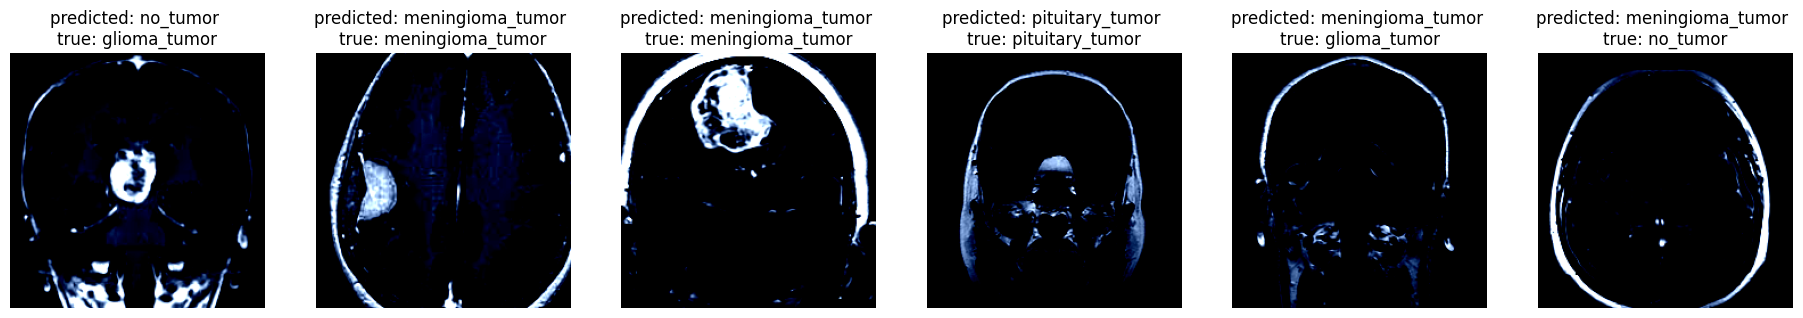

In [43]:
visualize_model(resnet, num_images=6)

### Training with Efficient Net

We can try to train with different pre-trained model. Here we will as usual freeze all the layers except the classifier part, and then train only on it instead of whole model. For that image size nees to be transformed to match the input features of 1280, given for efficientNet

In [ ]:
t_efficient_train = transforms.Compose([transforms.CenterCrop(224), transforms.ToTensor(),transforms.Grayscale(num_output_channels =1),transforms.Resize((40,32)), transforms.Normalize((0.48),(0.22)) ])
dataset_train_e = ImageFolder('./Training', transform=t_efficient_train) #
t_efficient_test = transforms.Compose([transforms.CenterCrop(224), transforms.ToTensor(),transforms.Grayscale(num_output_channels=1),transforms.Resize((40,32)),transforms.Normalize((0.48), (0.22))])
dataset_test_e = ImageFolder('./Testing', transform=t_efficient_test)


In [ ]:
#check shape
dataset_train_e[8][0].size()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([1, 40, 32])

In [ ]:
efficient = models.efficientnet_b1(weights = models.EfficientNet_B1_Weights)

#print(efficient) # check for which layer outputs need to be changed

# WORK IN PROGRESS

In [ ]:

efficient.classifier = nn.Linear(in_features=1280, out_features = 4)
for w in efficient.classifier.parameters():
    w.requires_grad=True

eff_opt = torch.optim.Adam(efficient.classifier.parameters(), lr = 0.0001)

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
dataloader_train_e= DataLoader(dataset_train_e, batch_size=4, shuffle=True)
dataloader_test_e =DataLoader(dataset_test_e, batch_size=4)